In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

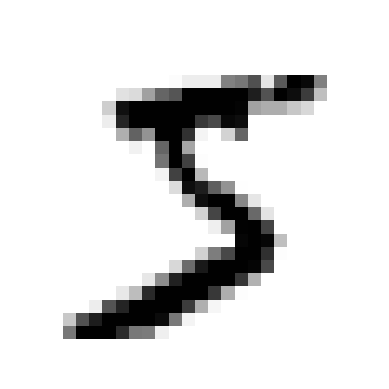

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
#
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")

In [5]:
y[0]

'5'

In [6]:
import numpy as np

y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [17]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [10]:
sgd_clf.predict([some_digit])

array([ True])

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
	clone_clf = clone(sgd_clf)

	X_train_folds = X_train[train_index]
	y_train_folds = y_train_5[train_index]

	X_test_fold = X_train[test_index]
	y_test_fold = y_train_5[test_index]

	clone_clf.fit(X_train_folds, y_train_folds)
	y_pred = clone_clf.predict(X_test_fold)
	n_correct = np.sum(y_pred == y_test_fold)
	print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
	def fit(self, X, y=None):
		return self

	def predict(self, X):
		return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
y_train_perfect_prediction = y_train_5
confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

In [17]:
from sklearn.metrics import precision_score

cm = confusion_matrix(y_train_5, y_train_pred)
precision = precision_score(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1]), precision


(np.float64(0.8370879772350012), 0.8370879772350012)

In [18]:
from sklearn.metrics import recall_score

recall = recall_score(y_train_5, y_train_pred)
cm[1, 1] / (cm[1, 0] + cm[1, 1]), recall

(np.float64(0.6511713705958311), 0.6511713705958311)

In [19]:
from sklearn.metrics import f1_score

f1_1 = 2 / ((1 / precision) + (1 / recall))
f1_2 = 2 * (precision * recall) / (precision + recall)
f1_3 = cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)
f1_4 = f1_score(y_train_5, y_train_pred)
f1_1, f1_2, f1_3, f1_4

(0.7325171197343847,
 0.7325171197343846,
 np.float64(0.7325171197343847),
 0.7325171197343847)

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores = cross_val_predict(
	sgd_clf,
	X_train,
	y_train_5,
	cv=3,
	method="decision_function"
)

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
	plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
	plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
	plt.legend(loc="center right", fontsize=16)
	plt.xlabel("Threshold", fontsize=16)
	plt.grid(True)
	plt.axis([-50000, 50000, 0, 1])


In [26]:
recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

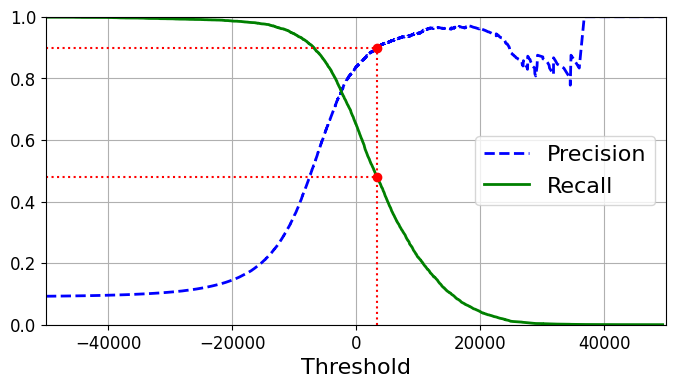

In [27]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

In [28]:
np.all(y_train_pred == (y_scores > 0))

np.True_

In [29]:
def plot_precision_vs_recall(precisions, recalls):
	plt.plot(recalls, precisions, "b-", linewidth=2)
	plt.xlabel("Recall", fontsize=16)
	plt.ylabel("Precision", fontsize=16)
	plt.axis([0, 1, 0, 1])
	plt.grid(True)

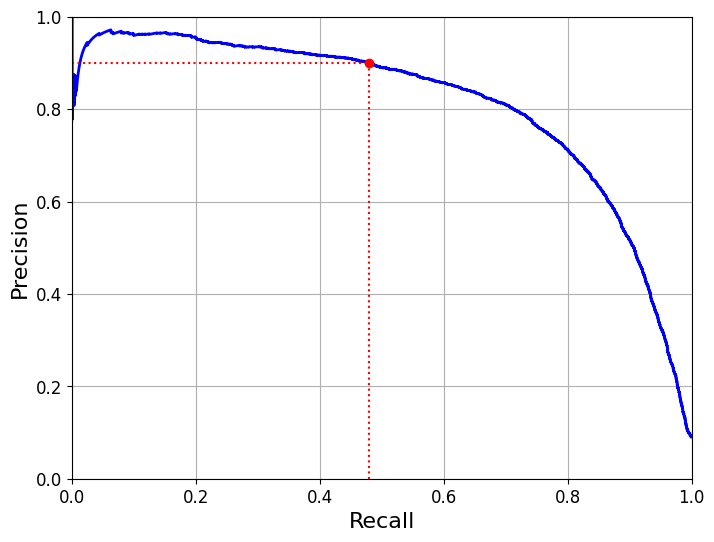

In [30]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [31]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

### The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool.
ROC curve plots the true positive rate (another name for recall) against the false positive rate(FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1- specificity

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
	plt.plot(fpr, tpr, linewidth=2, label=label)
	plt.plot([0, 1], [0, 1], "k--")
	plt.axis([0, 1, 0, 1])
	plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
	plt.ylabel('True Positive Rate (Recall)', fontsize=16)
	plt.grid(True)

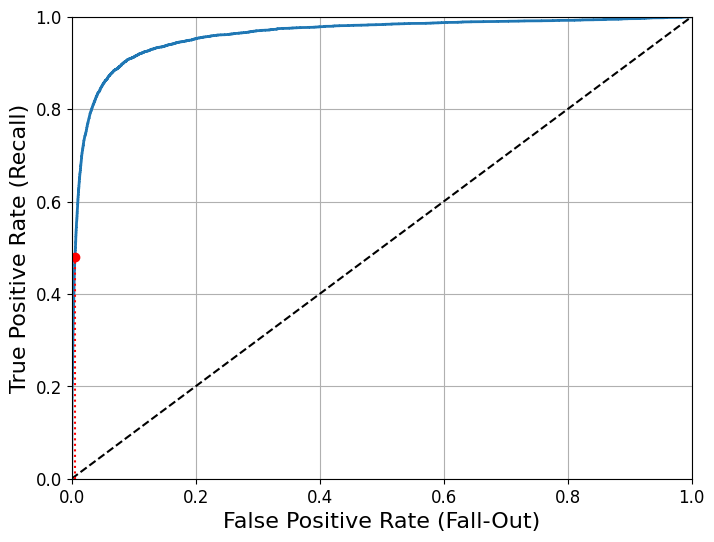

In [34]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

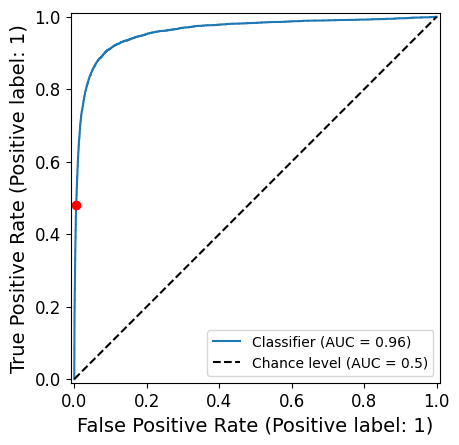

In [35]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(y_train_5, y_scores, plot_chance_level=True)
ax = display.ax_
ax.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
	forest_clf,
	X_train,
	y_train_5,
	cv=3,
	method="predict_proba"
)

In [38]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


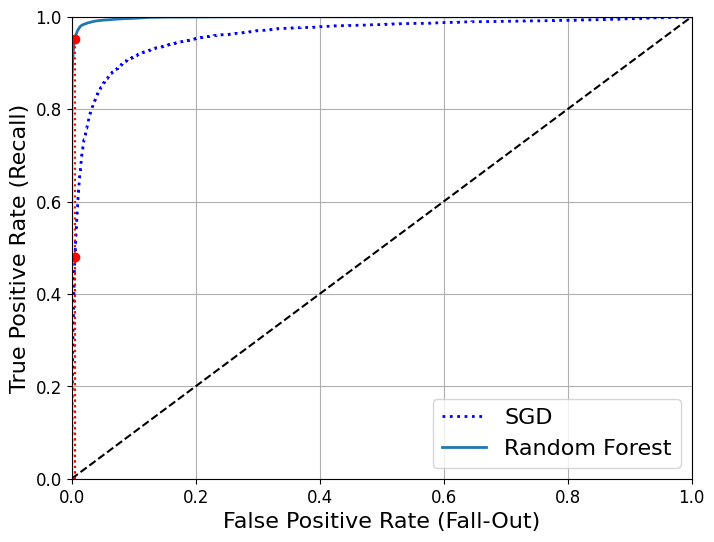

In [39]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

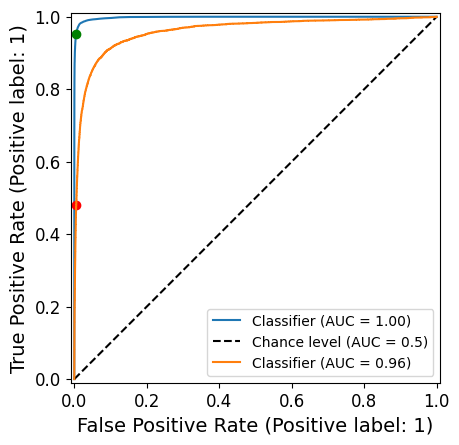

In [40]:
display = RocCurveDisplay.from_predictions(
	y_train_5,
	y_scores_forest,
	plot_chance_level=True
)
ax = display.ax_
ax.plot([fpr_90], [recall_90_precision], "ro")
ax.plot([fpr_90], [recall_for_forest], "go")
RocCurveDisplay.from_predictions(
	y_train_5,
	y_scores,
	ax=ax
)
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [42]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [43]:
precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest)

(0.9905083315756169, 0.8662608374838591)

### Multiclass Classification


1) *one-versus-the-rest* (OvR) strategy (also called *one-versus-all*):
	train 10 binary classifiers, one for each digit. Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score


2) *one-versus-one* (OvO) strategy:
	train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another for 0s and 2s, ... another for 1s and 2s and so on. If there are N classes, you need to train N x (N-1) / 2 classifier.





In [44]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [46]:
np.argmax(some_digit_scores), svm_clf.classes_

(np.int64(5), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

In [ ]:
ovr_clf.predict([some_digit]), len(ovr_clf.estimators_)

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
# cross_val_score(sgd_clf, X_train,y_train,cv=3,scoring="accuracy") # array([0.87365, 0.85835, 0.8689 ])

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=3)  # array([0.8983, 0.891 , 0.9018])

array([0.8983, 0.891 , 0.9018])

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [56]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
	size = 28
	images_per_row = min(len(instances), images_per_row)

	n_rows = (len(instances) - 1) // images_per_row + 1
	n_empty = n_rows * images_per_row - len(instances)
	padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
	image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
	big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
	plt.imshow(big_image, cmap=mpl.cm.binary, **options)
	plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel Classification

In [3]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

NameError: name 'y_train' is not defined

In [66]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
# Warning: the following cell may take a very long time (possibly hours depending on your hardware).
# knn_clf.predict([some_digit]) # array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=3)
f1_score(y_multilabel, y_train_knn_pred, avergae="macro")


### Multioutput Classification

The last type of classification task is called *multioutput-multiclass classification* or simply *multioutput classification*. It is simply a generalization of multilabel classification where each label can be multiclass


Let's build a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intensities.

Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system

In [57]:

X_train_mod = X_train + np.random.randint(0, 100, (len(X_train), 784))
X_test_mod = X_test + np.random.randint(0, 100, (len(X_test), 784))

y_train_mod = X_train
y_test_mod = X_test

In [11]:
def plot_digit(data):
	image = data.reshape(28, 28)
	plt.imshow(image, cmap=mpl.cm.binary,
			   interpolation="nearest")
	plt.axis("off")

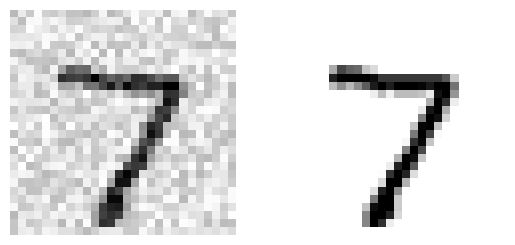

In [61]:
some_index = 0
plt.subplot(121)
plot_digit(X_test_mod[some_index])
plt.subplot(122)
plot_digit(y_test_mod[some_index])
plt.show()

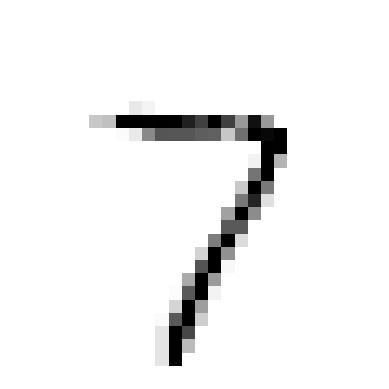

In [71]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [72]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

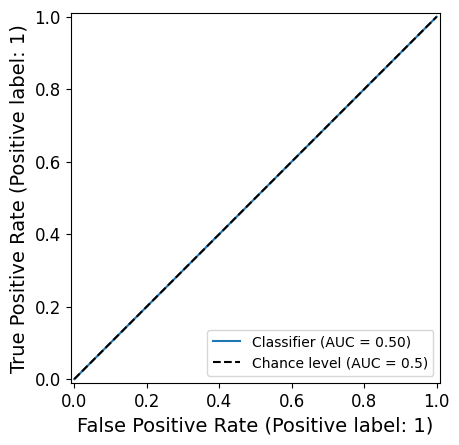

In [75]:
RocCurveDisplay.from_predictions(
	y_train_5,
	y_scores_dmy,
	plot_chance_level=True
)

In [77]:
knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=4)
knn_clf.fit(X_train, y_train)

,n_neighbors,4
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [78]:
y_knn_pred = knn_clf.predict(X_test)

In [79]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_knn_pred)

0.9714

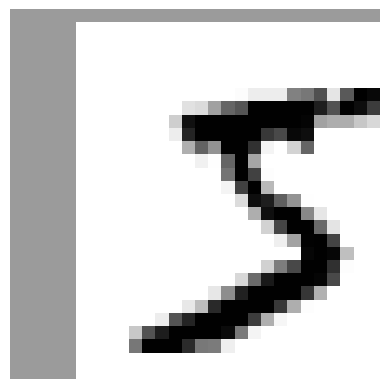

In [16]:
from scipy.ndimage import shift


def shift_digit(digit_array, dx, dy, new=0):
	return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)


plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [82]:
0
X_train_expanded = [X_train]
y_train_expanded = [y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
	shifted_image = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
	X_train_expanded.append(shifted_image)
	y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape


((300000, 784), (300000,))

In [83]:
knn_clf.fit(X_train_expanded, y_train_expanded)

,n_neighbors,4
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
 y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

In [ ]:
ambiguous_digit = X_test[250]
knn_clf.predict_proba([ambiguous_digit])

In [ ]:
plot_digit(ambiguous_digit)

### Exercises

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
	"weights": ["uniform", "distance"],
	"n_neighbors": [3, 4, 5]
}

grid_knn = GridSearchCV(
	estimator=KNeighborsClassifier(),
	param_grid=param_grid,
	cv=5,
	verbose=3,
	n_jobs=3,
)

In [ ]:
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
grid_knn.best_params_, grid_knn.best_score_

In [ ]:
y_pred = grid_knn.predict(X_test)
accuracy_score(y_test, y_pred)

2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.5 Then, for each image in the training set, create four shif‐
ted copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of
artificially growing the training set is called data augmentation or training set
expansion

In [8]:
def shift_image(image, dx, dy):
	image = image.reshape(28, 28)
	shifted_image = shift(image, [dx, dy], cval=0, mode="constant")
	return shifted_image.reshape([-1])

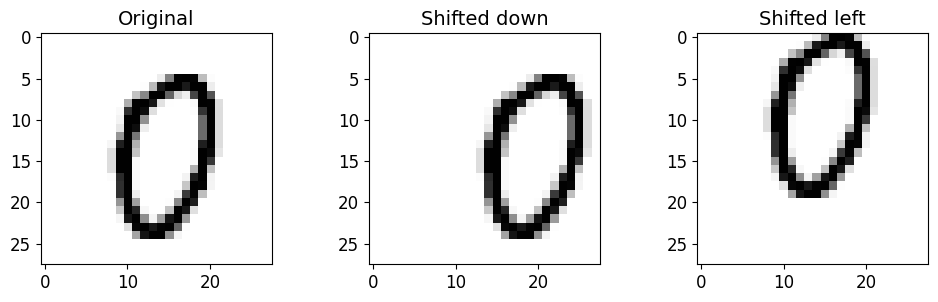

In [17]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [18]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
	for image, label in zip(X_train, y_train):
		X_train_augmented.append(shift_image(image, dx, dy))
		y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))

X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

knn_clf = KNeighborsClassifier(**grid_knn.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)